# Exploring the National Parks of the United States
> "Wilderness is not a luxury but a necessity of the human spirit, and as vital to our lives as water and good bread. A civilization which destroys what little remains of the wild, the spare, the original, is cutting itself off from its origins and betraying the principle of civilization itself." <br>***Edward Abbey***, [Desert Solitare](https://www.goodreads.com/book/show/214614.Desert_Solitaire?ac=1&from_search=true&qid=3inpz3msB9&rank=1)<br><br>
"Like winds and sunsets, wild things were taken for granted until progress began to do away with them. Now, we face the question whether a still higher 'standard of living' is worth its cost in things natural, wild and free." <br>***Aldo Leopold***, [A Sand County Almanac](https://www.aldoleopold.org/about/aldo-leopold/sand-county-almanac/)

The United States and its territories are home to [sixty-three national parks](https://www.nationalgeographic.com/travel/article/beautiful-photos-of-all-us-national-parks?rid=1E8B7B3947E0EBECE8AF71C1C3BD31D6&cmpid=org=ngp::mc=crm-email::src=ngp::cmp=editorial::add=Compass_20220702) that are maintained by the Dept. of the Interior's [National Park Service (NPS)](https://irma.nps.gov/STATS/). The NPS was created through the [Organic Act of 1916](https://www.nps.gov/grba/learn/management/organic-act-of-1916.htm) "to conserve the scenery and the natural and historic objects and wildlife therein, and to provide for the enjoyment of the same in such manner and by such means as will leave them unimpaired for the enjoyment of future generations." 

The natural beauty of public lands in the United States attract visitors from all over the world. I first truly experienced the national parks while living in Utah, home to ['The Might 5'](https://www.visitutah.com/places-to-go/parks-outdoors/the-mighty-5) parks. The oddity, vastness, and resilience of life in the desert left an impression. I also saw the designation of [Bear Ears National Monument](https://bearsearsmonument.org/), lead by dedicated efforts of the [Bears Ears Inter-Tribal Coalition](https://www.bearsearscoalition.org/), a collective of sovereign tribal nations. Since being designated, the size of Bears Ears has yo-yoed due to political and economic interest, a common problem for public lands in the US (see e.g. this [Patagonia Films documentary](https://www.youtube.com/watch?v=OGjnIG7puzY)).

Economic development isn't the only threat to public lands. Visitation to the national parks continues to increase each year, leading [some parks to require reservations](https://www.tripsavvy.com/national-parks-requiring-timed-entry-tickets-2022-5215453). Paired with growing concerns due to climate change, the national parks may be on the brink of overuse and degradation.<br><br>

**GOAL:** *(1)* Characterize recreational use of the national parks; *(2)* explore sustainability of the parks in the face of a changing climate; and *(3)* learn how to scrape and visualize data from a webpage.<br>
**DATA:** Publicly avaialable data on use of the national parks will be scrapped from the NPS website. TBD where to access data on climate change impact.<br>
**ANALYSIS:** Exploratory data analysis to gain insights into the dataset.<br>
**ETHICAL CONSIDERATIONS:** There are no apparent issues with privacy, transparency,
or accountability in terms of avaiable data. Whether access to the national parks is equitable across communities in the US should be considered further. The NPS has begun administering a [survey](https://www.nps.gov/subjects/socialscience/socioeconomic-monitoring-visitor-surveys.htm) to understand who accesses the parks, and whether access differs as a function of demographic and economic factors. I'd like to incorporate data from that survey into this notebook when it becomes publicly available.<br>
**ADDITIONAL CONSIDERATIONS:** None.

## Load libraries

In [1]:
import os

# webscraping
import requests as rq
from bs4 import BeautifulSoup

# data wrangling/analysis
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Create parks data frame 
First step is to compile a data frame of the national parks in the United States. For practice, I will scrape this information from this [wiki page](https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States). 

In [2]:
# url to scrape information from
wiki = 'https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States'

In [3]:
# extract HTML text
page = rq.get(wiki).text

# convert to BeautifulSoup object
soup = BeautifulSoup(page)

In [4]:
# find <table> tag that match our class name
table = soup.find('table', class_='wikitable sortable plainrowheaders')

# find <tr> tags in our specified table, ignoring the labels row
parks_table = table.find_all('tr')[1:]

In [5]:
# create empty list to store park information
parks_list = []

In [6]:
# Loop through each park in the website's table
for park in parks_table:
    
    # extract name from <a> tag
    name = park.find('a').get('title')

    # extract state/teritory from specific <a> tag
    state_terr = park.find_all('a')[2].get('title')
    
    # extract date established from specific <span> tag
    established = park.find_all('span')[13].get('data-sort-value')
    established = pd.to_datetime(established[8:-5]).date()
                                
    # extract park decimal coordinates from tags
    coordinates = park.find(attrs={'class':'span', 'class':'geo'})
    latitude = coordinates.text.split(';')[0]
    longitude = coordinates.text.split(';')[1]
    
    # append information to full parks dataframe
    parks_list.append([name, state_terr, latitude, longitude, established])

In [7]:
# create list of NPS park abbreviations
parks_abrv = ['ACAD', 'NPAS', 'ARCH', 'BADL', 'BIBE', 'BISC', 'BLCA', 'BRCA', 'CANY', 'CARE', 
              'CAVE', 'CHIS', 'CONG', 'CRLA', 'CUVA', 'DEVA', 'DENA', 'DRTO', 'EVER', 'GAAR', 
              'JEFF', 'GLAC', 'GLBA', 'GRCA', 'GRTE', 'GRBA', 'GRSA', 'GRSM', 'GUMO', 'HALE', 
              'HAVO', 'HOSP', 'INDU', 'ISRO', 'JOTR', 'KATM', 'KEFJ', 'KICA', 'KOVA', 'LACL', 
              'LAVO', 'MACA', 'MEVE', 'MORA', 'NERI', 'NOCA', 'OLYM', 'PEFO', 'PINN', 'REDW', 
              'ROMO', 'SAGU', 'SEQU', 'SHEN', 'THRO', 'VIIS', 'VOYA', 'WHSA', 'WICA', 'WRST', 
              'YELL', 'YOSE', 'ZION']

In [8]:
# append NPS abbrevations to parks list
for x, y in zip(parks_list, parks_abrv):
    x.append(y)

In [120]:
# create parks dataframe
parks = pd.DataFrame(parks_list,
                     columns=['name', 'state_terr', 'latitude', 'longitude', 'est_date', 'nps_abrv'])

In [121]:
# tidy variable types 
parks['est_date'] = pd.to_datetime(parks.est_date, errors='ignore')
parks[['latitude', 'longitude']] = parks[['latitude', 'longitude']].astype(float)

# tidy variable name
parks['state_terr'] = parks['state_terr'].replace('Washington (state)', 'Washington')

Retrieved shapefile maps from the US Census Bureau by following [this tutorial](https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77).

In [122]:
# define path to census shapefile
dir_name = os.getcwd()
shape_file = dir_name + '/tl_2021_us_state/tl_2021_us_state.shp'

In [123]:
# load shapefile
map_df = gpd.read_file(shape_file)
map_df = map_df.to_crs("EPSG:4326")

In [116]:
# preview dataframe
map_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266298634,489204185,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138961722096,45972570361,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778561906,6216493488,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232627084,18949394733,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151992308,6979074857,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373..."


In [124]:
# tidy dataframe
map_df.columns = map(str.lower, map_df.columns)
map_df.rename(columns={'name':'state_terr'}, inplace=True) 

In [125]:
# create new dataframe with select variables 
regions = map_df[['region','state_terr']].copy()

# left merge regions and parks dateframes, by state_terr
parks = parks.merge(regions, on='state_terr', how='left')

In [129]:
# tidy variable name
parks['state_terr'] = parks['state_terr'].replace('United States Virgin Islands', 'Virgin Islands')

# recode regions column
#parks['region'] = parks['region']\
#    .rename_categories({'1': 'Northeast',
#                        '2': 'Midwest',
#                        '3': 'South',
#                        '4': 'South',
#                        '9': 'Territories'})

In [130]:
parks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   name        63 non-null     object        
 1   state_terr  63 non-null     object        
 2   latitude    63 non-null     float64       
 3   longitude   63 non-null     float64       
 4   est_date    63 non-null     datetime64[ns]
 5   nps_abrv    63 non-null     object        
 6   region      63 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 3.9+ KB


In [131]:
# preview dataframe
parks.head()

,name,state_terr,latitude,longitude,est_date,nps_abrv,region
0,Acadia National Park,Maine,44.35,-68.21,1919-02-26,ACAD,1
1,National Park of American Samoa,American Samoa,-14.25,-170.68,1988-10-31,NPAS,9
2,Arches National Park,Utah,38.68,-109.57,1971-11-12,ARCH,4
3,Badlands National Park,South Dakota,43.75,-102.50,1978-11-10,BADL,2
4,Big Bend National Park,Texas,29.25,-103.25,1944-06-12,BIBE,3


Great! We now have a data frame with key information for each national parks in the United States.

## Location of parks
Twenty-eight states and two territories have at least one national park in the United States, with California having the most with 9 designated parks. 

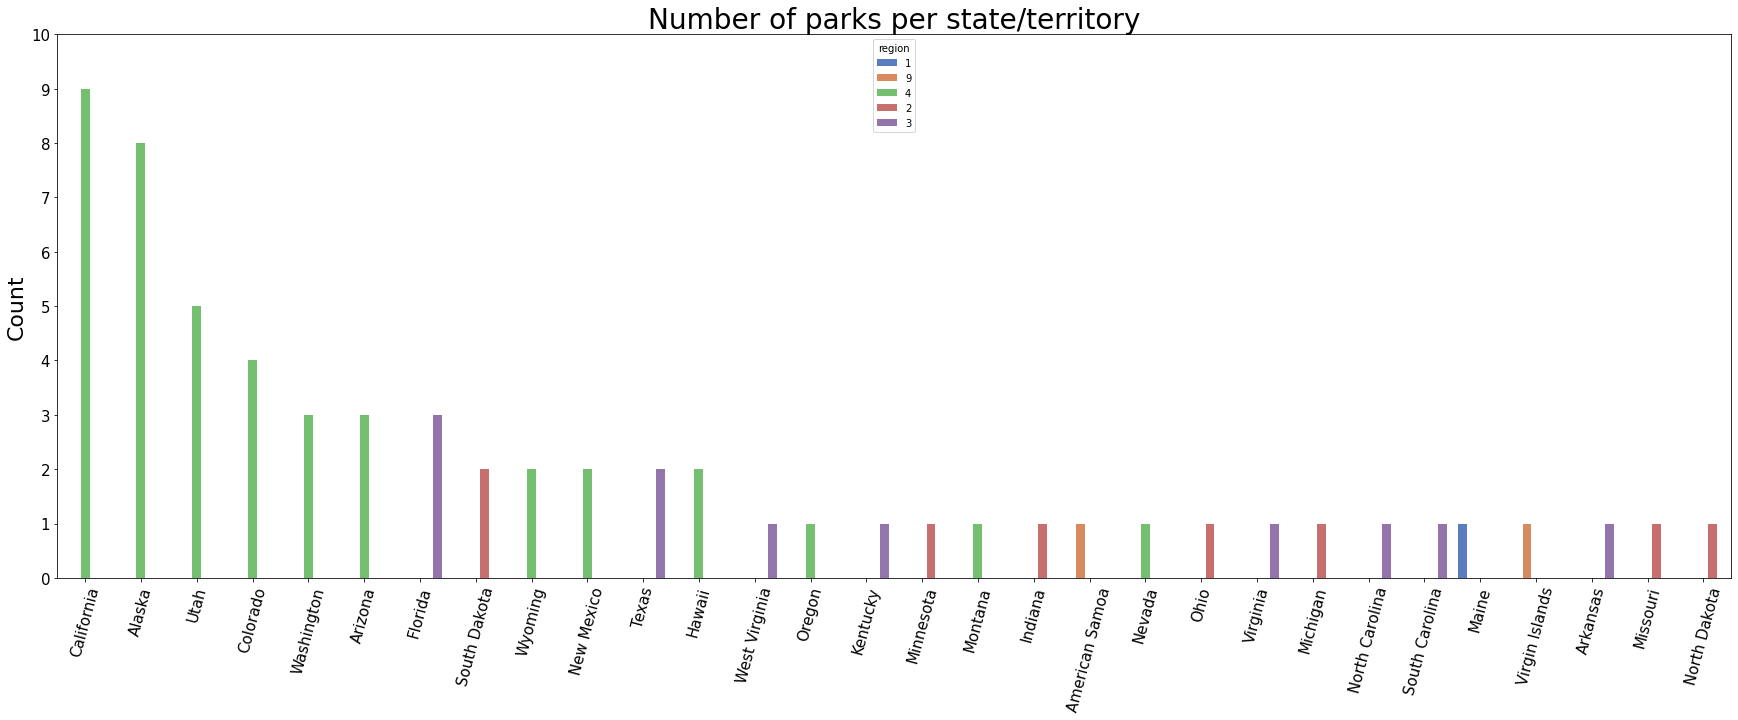

In [132]:
plt.figure(figsize=(30,10))

ax = sns.countplot(data=parks,
                   x='state_terr',
                   hue='region',
                   order=parks.state_terr.value_counts().index,
                   palette='muted')
ax.set_title('Number of parks per state/territory', fontsize=28)
ax.set_yticks(np.arange(0, 11))
plt.xlabel(None)
plt.ylabel("Count", fontsize=22)
plt.xticks(fontsize=15, rotation=75)
plt.yticks(fontsize=15)

plt.show()

[Geopandas documentation](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) will be useful as I continue to work on the figure below. Right now its a hodgepodge of code snippets.

In [19]:
gdf = gpd.GeoDataFrame(parks, 
                       geometry=gpd.points_from_xy(parks.longitude, parks.latitude))

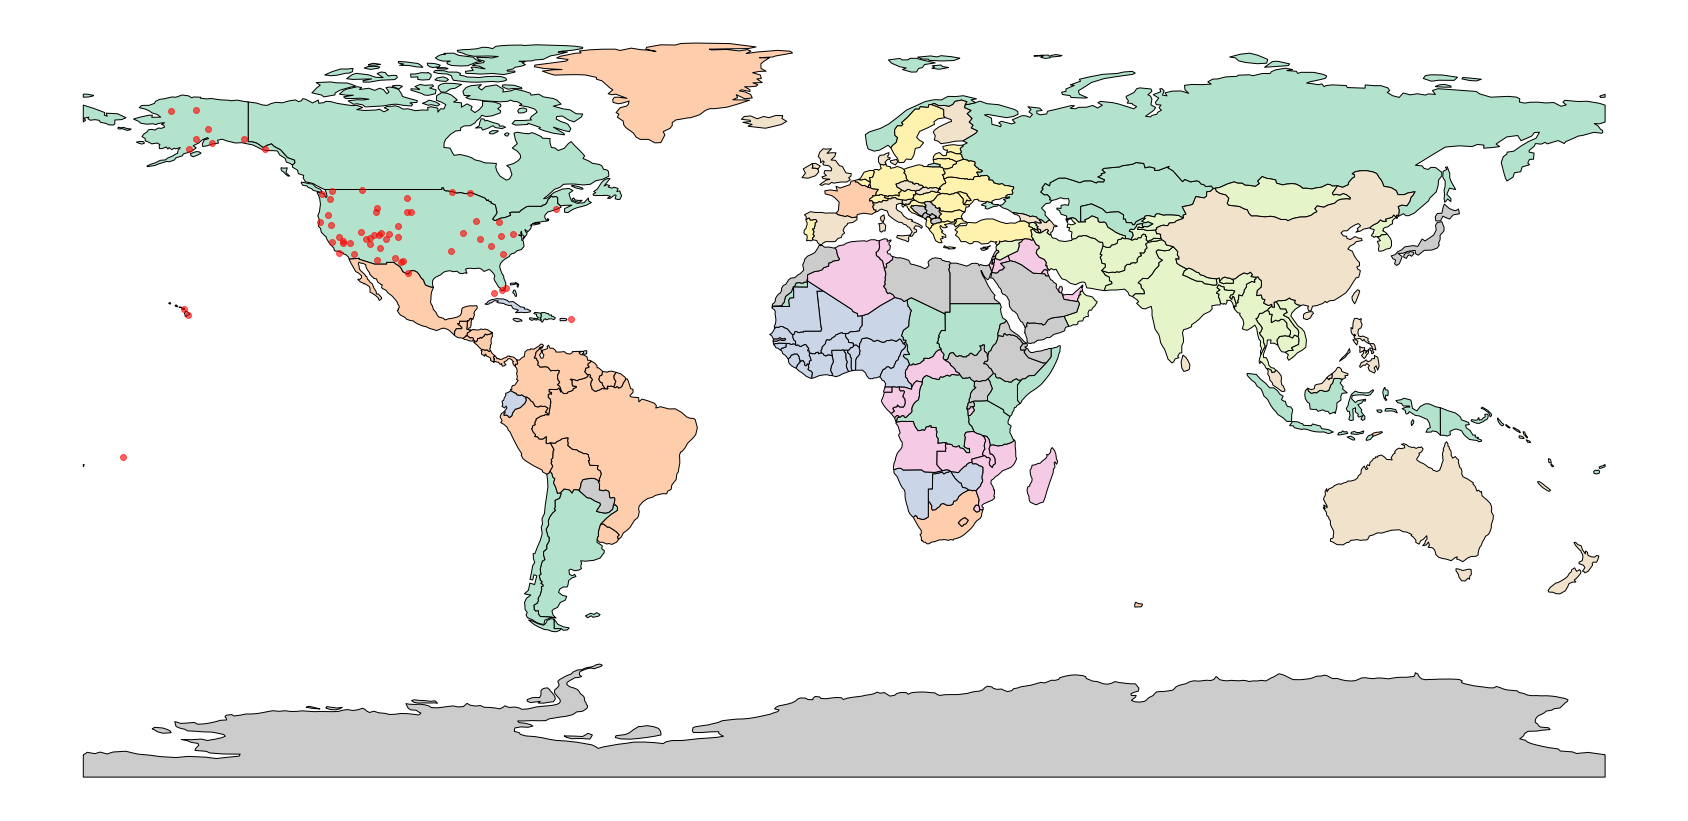

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(cmap='Pastel2', edgecolor='black', figsize=(30,20))
ax.set_axis_off()
gdf.plot(ax=ax, alpha=0.6, color='red')

plt.show()

In [21]:
# start with continential US only 
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = map_df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

AttributeError: 'GeoDataFrame' object has no attribute 'STUSPS'

In [ ]:
# create a basic continential US figure
f,ax = plt.subplots(1,1, figsize=(6,4), dpi=300)
divider = make_axes_locatable(ax)
ax.set_axis_off()
us49.plot(ax=ax, alpha=0.5, cmap='gist_earth', edgecolor='k', legend=False, linewidth=0.1)
gdf.plot(ax=ax, alpha=0.6, color='red')
plt.show()

Need to select parks in the continential US from gdf dataframe, to match with this plot. Getting closer!

## Scrape NPS data

In [ ]:
# url to scrape information from
nps = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park={}'

In [ ]:
# create empty list to store park data
#parks_data = []

# temporary parks list for testing
test_park = ['ACAD']

In [ ]:
for park in test_park:
    
    # url to monthly data for each park 
    url = nps.format(park)
    
    # extract HTML text
    page = rq.get(url).text
    print(page)
    
    # convert to BeautifulSoup object
    #soup = BeautifulSoup(page)
    
    # pull <table> tag that match our class name
    #table = soup.find('table', class_ = 'Ae30f20f368af4927806ac09a734045d0170')
    
    # find <tr> tags in our specified table, ignoring the labels row
    #temp_table = table.find_all('tr')
    
    # extract park name from <a> tag
    #xyz = park.find('a').get('xyz')
    
    # append information to full parks list
    #park_data.append(xyz)

There seems to be an issue with extracting the HTML text from the webpage. Maybe that's due to javascript? Unclear. There is another popular web-scraping tool called [Selenium](https://oxylabs.io/blog/selenium-web-scraping) that is suppose to work with javascript. I'll try that out next.<br><br>***To be continued***